## Follows Create_TSS_by_tissue

If multiple peaks with an associated landmark (isoform, gene, or gene_id) take the max value.  
Puts into bed format, extracts fasta for each peak

In [1]:
import os
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Tahoma']
import tqdm
### notebook specific configuration ###
from os.path import basename

from Modules.Homer import *

sys.path.append('/home/isshamie/software/NGS-Pipeline')

data_folder = '/data/isshamie/CH_tissue_TSS/'

ref_fa = '/data/genome/hamster/picr/picr.fa'
annotation = '/data/genome/hamster/picr/updated_final_sort.gff3'
tss_annotation = '/data/isshamie/genome/start_site_mRNA_updated_final_sort.tsv'
mrna_peak = '/data/isshamie/TSS_CHO/mRNA.peak'

tissues = ['BloondnegSpleen','BMDM1hKLA1','BMDMwt','Brain','Brain7neg1',
          'FemaleReproductive','Heart','Intestine','Kidney','Liver','Lung',
           'MiscOrgans','Muscle','Pancreas','Skin','Spleen','Total','CHO']

len(tissues)

### Load in meta_sampe

meta_samples = pd.read_csv('Results/meta_samples.csv',index_col=0)

long_meta_samples = pd.read_csv('Results/long_meta_samples.csv',index_col=0)


/home/isshamie/software/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
gene_pd = pickle.load(open("Results/gene_pd.p",'rb'))

In [3]:
gene_pd.head()

,Peaks,Number of Peaks,Tissues,minDistance,sameStrandPeaks,minDistancePeak,maxValue,Peaks within -1kb:+100bp,tissues,hasGene,Number of SS
SERHL,"[Merged-picr_74-10067740-3, Merged-picr_0-2095...",9,NaN,31,"[Merged-picr_74-10067740-3, Merged-picr_0-2095...",Merged-picr_0-20958-19,NaN,"[Merged-picr_74-10067740-3, Merged-picr_0-2095...","[BloondnegSpleen_GRO, BMDM1hKLA1_GRO, BMDMwt_G...",True,2
RRP7A,"[Merged-picr_10-20507340-5, Merged-picr_10-210...",27,NaN,-19,"[Merged-picr_0-44492-5, Merged-picr_0-45924-1]",Merged-picr_0-44492-5,NaN,"[Merged-picr_0-44634-10, Merged-picr_0-44492-5...","[BloondnegSpleen_GRO, BMDM1hKLA1_GRO, BMDMwt_G...",True,2
POLDIP3,"[Merged-picr_0-78615-16, Merged-picr_0-98823-1...",46,NaN,46,"[Merged-picr_0-98823-17, Merged-picr_0-78294-1...",Merged-picr_0-78294-15,NaN,"[Merged-picr_0-98823-17, Merged-picr_0-98958-1...","[BloondnegSpleen_GRO, BMDM1hKLA1_GRO, BMDMwt_G...",True,4
CYB5R3,"[Merged-picr_0-94356-1, Merged-picr_0-92870-1,...",17,NaN,5,"[Merged-picr_0-92205-1, Merged-picr_0-91214-1]",Merged-picr_0-92205-1,NaN,"[Merged-picr_0-92205-1, Merged-picr_0-91214-1]","[BloondnegSpleen_GRO, BMDMwt_GRO]",True,2
A4GALT,"[Merged-picr_0-185729-11, Merged-picr_0-183445...",42,NaN,-5,"[Merged-picr_0-185729-11, Merged-picr_0-186286...",Merged-picr_0-186286-5,NaN,"[Merged-picr_0-185729-11, Merged-picr_0-185806...","[BloondnegSpleen_GRO, BMDM1hKLA1_GRO, BMDMwt_G...",True,3


In [4]:
anno_peaks = pd.read_csv('Results/peaks_with_tss_and_gene.tsv',sep='\t',index_col=0)
#anno_peaks = anno_peaks[['Chr','Start','End','Strand','Peak Score','Nearest TSS','isSameStrand','Distance to TSS']]
anno_peaks = anno_peaks[~anno_peaks['Nearest TSS'].isnull()]

## Get genes that are in the new genome

In [5]:
tss = pd.read_csv(tss_annotation,sep='\t',index_col=0)

In [23]:
tss

,Chr,Start,End,Strand,ID,Parent,gene_id,gene,transcript_id,cs,Length
ID=asmbl_2;Parent=gene_1_2;gene_id=gene_1_2;gene=SERHL;transcript_id=asmbl_2;cs=2,picr_0,176,38694,+,asmbl_2,gene_1_2,gene_1_2,SERHL,asmbl_2,2,38518
ID=asmbl_4;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_4;cs=1,picr_0,7715,46630,-,asmbl_4,gene_2,gene_2,RRP7A,asmbl_4,1,38915
ID=asmbl_7;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_7;cs=1,picr_0,7759,44597,-,asmbl_7,gene_2,gene_2,RRP7A,asmbl_7,1,36838
ID=asmbl_8;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_8;cs=1,picr_0,7767,44597,-,asmbl_8,gene_2,gene_2,RRP7A,asmbl_8,1,36830
ID=asmbl_9;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_9;cs=1,picr_0,7789,44568,-,asmbl_9,gene_2,gene_2,RRP7A,asmbl_9,1,36779
ID=asmbl_10;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_10;cs=1,picr_0,7821,44513,-,asmbl_10,gene_2,gene_2,RRP7A,asmbl_10,1,36692
ID=asmbl_11;Parent=gene_1_4;gene_id=gene_1_4;gene=SERHL;transcript_id=asmbl_11;cs=2,picr_0,18149,43772,+,asmbl_11,gene_1_4,gene_1_4,SERHL,asmbl_11,2,25623
ID=asmbl_12;Parent=gene_1_4;gene_id=gene_1_4;gene=SERHL;transcript_id=asmbl_12;cs=2,picr_0,20787,42039,+,asmbl_12,gene_1_4,gene_1_4,SERHL,asmbl_12,2,21252
ID=asmbl_14;Parent=gene_1_4;gene_id=gene_1_4;gene=SERHL;transcript_id=asmbl_14;cs=2,picr_0,20942,38694,+,asmbl_14,gene_1_4,gene_1_4,SERHL,asmbl_14,2,17752
ID=asmbl_15;Parent=gene_1_4;gene_id=gene_1_4;gene=SERHL;transcript_id=asmbl_15;cs=4,picr_0,22504,23694,+,asmbl_15,gene_1_4,gene_1_4,SERHL,asmbl_15,4,1190


In [6]:
peak_tissue_matrix = pd.read_csv('Results/merged_samples/peaks_tissues.csv',index_col=0,sep=',')
cho = peak_tissue_matrix.loc[:,peak_tissue_matrix.columns.str.contains('CHO')]

## Need to re-run the Distance to TSS because the negative strand was looking at the terminal region.
## Assuming the gene_id and transcript didnt change, which may not be the case for two nearby genes

### Distance of -1000:+100

In [ ]:
experimental_tss = tss.copy()

In [30]:
anno_peaks

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Distance to TSS,Nearest PromoterID,Nearest TSS,isSameStrand,Nearest gene,Nearest gene_id
PeakID (cmd=annotatePeaks.pl Results/merged_samples/all_peaks_merged.tsv /data/genome/hamster/picr/picr.fa -gff /data/genome/hamster/picr/updated_final_sort.gff3),,,,,,,,,,,,,
Merged-picr_33-4827737-13,picr_33,4827637,4827815,+,257024.156250,BloondnegSpleen/GRO/f04_peaks/merge_bg_2.peak|...,promoter-TSS (ID=asmbl_45526.exon1;Parent=asmb...,4.0,ID=asmbl_45526.exon1;Parent=asmbl_45526;gene_i...,asmbl_45526,True,CPA2,gene_16120
Merged-picr_76-305376-1,picr_76,305301,305451,-,146752.250000,Heart/mSTART/f04_peaks/merge_bg_2.peak,Intergenic,-23522.0,ID=asmbl_75726.exon1;Parent=asmbl_75726;gene_i...,asmbl_75726,False,OR1S1,gene_26766
Merged-picr_13-30535400-10,picr_13,30535313,30535549,+,125967.843750,BloondnegSpleen/GRO/f04_peaks/merge_bg_2.peak|...,promoter-TSS (ID=asmbl_16622.exon1;Parent=asmb...,310.0,ID=asmbl_16611.exon1;Parent=asmbl_16611;gene_i...,asmbl_16611,False,PARP16,gene_5744
Merged-picr_54-9283439-7,picr_54,9283364,9283514,+,112087.937500,BMDM1hKLA1/GRO/f04_peaks/merge_bg_2.peak|BMDMw...,promoter-TSS (ID=asmbl_62507.exon7;Parent=asmb...,-1781.0,ID=asmbl_62507.exon6;Parent=asmbl_62507;gene_i...,asmbl_62504,True,SURF2,gene_22133
Merged-picr_54-1311935-11,picr_54,1311860,1312010,+,78140.289062,Brain/mSTART/f04_peaks/merge_bg_2.peak|FemaleR...,Intergenic,69544.0,ID=asmbl_62111.exon1;Parent=asmbl_62111;gene_i...,asmbl_62111,True,LOC103161659,gene_22001
Merged-picr_16-22007182-8,picr_16,22007101,22007263,+,54882.019531,BMDM1hKLA1/GRO/f04_peaks/merge_bg_2.peak|Brain...,promoter-TSS (ID=asmbl_24869.exon2;Parent=asmb...,-25868.0,ID=asmbl_24869.exon2;Parent=asmbl_24869;gene_i...,asmbl_24876,True,DSCAML1,gene_8431
Merged-picr_64-11363665-18,picr_64,11363589,11363741,+,54377.167969,BloondnegSpleen/GRO/f04_peaks/merge_bg_2.peak|...,Intergenic,-42355.0,ID=asmbl_69800.exon2;Parent=asmbl_69800;gene_i...,asmbl_69802,True,GRM3,gene_24621
Merged-picr_9-17081479-10,picr_9,17081404,17081554,+,40572.980469,Brain/mSTART/f04_peaks/merge_bg_2.peak|FemaleR...,Intergenic,-415580.0,ID=asmbl_83553.exon1;Parent=asmbl_83553;gene_i...,asmbl_83564,True,NDST4,gene_29494
Merged-picr_73-107322-18,picr_73,107245,107399,+,39272.023438,BloondnegSpleen/GRO/f04_peaks/merge_bg_2.peak|...,promoter-TSS (ID=asmbl_74014.exon1;Parent=asmb...,2.0,ID=asmbl_74014.exon1;Parent=asmbl_74014;gene_i...,asmbl_74014,True,DNAJB6,gene_26235


In [9]:
gene_has_peak

,Peaks,Number of Peaks,Tissues,minDistance,sameStrandPeaks,minDistancePeak,maxValue,Peaks within -1kb:+100bp,tissues,hasGene,Number of SS,is_in_cho_all,is_in_cho_promoter,loc_differences
SERHL,"[Merged-picr_74-10067740-3, Merged-picr_0-2095...",9,NaN,31,"[Merged-picr_74-10067740-3, Merged-picr_0-2095...",Merged-picr_0-20958-19,NaN,"[Merged-picr_74-10067740-3, Merged-picr_0-2095...","[BloondnegSpleen_GRO, BMDM1hKLA1_GRO, BMDMwt_G...",True,2,True,True,[]
RRP7A,"[Merged-picr_10-20507340-5, Merged-picr_10-210...",27,NaN,-19,"[Merged-picr_0-44492-5, Merged-picr_0-45924-1]",Merged-picr_0-44492-5,NaN,"[Merged-picr_0-44634-10, Merged-picr_0-44492-5...","[BloondnegSpleen_GRO, BMDM1hKLA1_GRO, BMDMwt_G...",True,2,True,True,[]
POLDIP3,"[Merged-picr_0-78615-16, Merged-picr_0-98823-1...",46,NaN,46,"[Merged-picr_0-98823-17, Merged-picr_0-78294-1...",Merged-picr_0-78294-15,NaN,"[Merged-picr_0-98823-17, Merged-picr_0-98958-1...","[BloondnegSpleen_GRO, BMDM1hKLA1_GRO, BMDMwt_G...",True,4,True,True,[353.0]
CYB5R3,"[Merged-picr_0-94356-1, Merged-picr_0-92870-1,...",17,NaN,5,"[Merged-picr_0-92205-1, Merged-picr_0-91214-1]",Merged-picr_0-92205-1,NaN,"[Merged-picr_0-92205-1, Merged-picr_0-91214-1]","[BloondnegSpleen_GRO, BMDMwt_GRO]",True,2,True,False,[991.0]
A4GALT,"[Merged-picr_0-185729-11, Merged-picr_0-183445...",42,NaN,-5,"[Merged-picr_0-185729-11, Merged-picr_0-186286...",Merged-picr_0-186286-5,NaN,"[Merged-picr_0-185729-11, Merged-picr_0-185806...","[BloondnegSpleen_GRO, BMDM1hKLA1_GRO, BMDMwt_G...",True,3,True,False,[756.0]
ARFGAP3,"[Merged-picr_0-298201-12, Merged-picr_0-275652...",28,NaN,-26,"[Merged-picr_0-298201-12, Merged-picr_0-275652...",Merged-picr_0-298201-12,NaN,"[Merged-picr_0-298201-12, Merged-picr_0-275652...","[BloondnegSpleen_GRO, BMDM1hKLA1_GRO, BMDMwt_G...",True,3,True,True,[317.0]
PACSIN2,"[Merged-picr_0-398821-18, Merged-picr_0-399078...",73,NaN,-19,"[Merged-picr_0-398821-18, Merged-picr_0-364378...",Merged-picr_0-364378-13,NaN,"[Merged-picr_0-398821-18, Merged-picr_0-364378...","[BloondnegSpleen_GRO, BMDM1hKLA1_GRO, BMDMwt_G...",True,3,True,True,[364.0]
TTLL1,"[Merged-picr_0-440918-16, Merged-picr_0-441056...",6,NaN,-43,[Merged-picr_0-440918-16],Merged-picr_0-440918-16,NaN,[Merged-picr_0-440918-16],"[BloondnegSpleen_GRO, BMDM1hKLA1_GRO, BMDMwt_G...",True,1,True,False,[]
BIK,"[Merged-picr_0-470591-1, Merged-picr_0-457774-...",16,NaN,-9,"[Merged-picr_0-470591-1, Merged-picr_0-456863-...",Merged-picr_0-470591-1,NaN,"[Merged-picr_0-470591-1, Merged-picr_0-456863-...","[Liver_GRO, CHO_GRO, CHO_mSTART]",True,3,True,True,[389.0]
MCAT,"[Merged-picr_0-491597-11, Merged-picr_0-492294...",10,NaN,-12,[Merged-picr_0-491506-6],Merged-picr_0-491506-6,NaN,"[Merged-picr_0-491597-11, Merged-picr_0-491506-6]","[BloondnegSpleen_GRO, BMDM1hKLA1_GRO, BMDMwt_G...",True,1,True,True,[]


In [32]:
def get_peaks_within_distance(peaks,distance=[-1000,+100]):  
    filt = peaks[(peaks['Distance to TSS'] > distance[0]) & (peaks['Distance to TSS'] < distance[1])]
    return filt


In [73]:
from tqdm import tqdm_notebook

In [74]:
experimental_tss = pd.DataFrame(columns=['gene','tissues','transcript',
                                         'Start','End','max_value','max_peak_id',
                                         'cs','in_CHO'],index=anno_peaks['Nearest TSS'].unique())
experimental_tss['in_CHO'] = False
experimental_tss['tissues'] = ''

for ind,val in tqdm_notebook(experimental_tss.iterrows()):
    experimental_tss.set_value(ind,'cs',int(tss[tss['transcript_id'] == ind]['cs']))
    
    curr = anno_peaks[anno_peaks['Nearest TSS'] == ind]
    #Filter for isSameStrand and btwn -100 and 1kb 
    curr = curr[curr['isSameStrand']]
    curr = get_peaks_within_distance(curr,distance=[-1000,+100]) 
    curr_tss_peaks = peak_tissue_matrix[peak_tissue_matrix.index.isin(curr.index)]

    if len(curr_tss_peaks) == 0:
        continue     

    ## Tissues
    try: 
        curr_tissues = peak_tissue_matrix.columns[(peak_tissue_matrix.loc[curr.index]>0).any()].values
        curr_tissues = map(lambda x: x.split('/')[0],curr_tissues)
        experimental_tss.set_value(ind,'tissues',set(curr_tissues))
        
        if 'CHO' in curr_tissues:
            experimental_tss.set_value(ind,'is_in_cho_promoter', True)   
        
    except KeyError :
        print curr.index + ' not in peak expression file. Maybe it was dropped from being a duplicate? Or no peak had a value in it.'
    
    
    
    if len(curr_tss_peaks) > 1:
        max_peak = curr_tss_peaks.max(axis=1).argmax()
        max_value = curr_tss_peaks.max(axis=1).max()
    else:
        max_peak = curr_tss_peaks.index[0]
        max_value = curr_tss_peaks.max().max()
    
    
    tmp = anno_peaks.loc[max_peak]
    
    experimental_tss.set_value(ind,'max_value',max_value)
    experimental_tss.set_value(ind,'max_peak_id',max_peak)
    experimental_tss.set_value(ind,'transcript',tmp['Nearest TSS'])
    experimental_tss.set_value(ind,'gene',tmp['Nearest gene'])
    experimental_tss.set_value(ind,'gene_id',tmp['Nearest gene_id'])
    experimental_tss.set_value(ind,'Start',tmp['Start'])
    experimental_tss.set_value(ind,'End',tmp['End'])
    experimental_tss.set_value(ind,'Chr',tmp['Chr'])
    experimental_tss.set_value(ind,'Strand',tmp['Strand'])
    experimental_tss.set_value(ind,'Distance to Annotated TSS',tmp['Distance to TSS'])


In [77]:
experimental_tss = experimental_tss.sort_values(['Chr','Start','End'])

In [78]:
experimental_tss.to_pickle('Results/tss_final/experimental_tss.p')


In [96]:
experimental_tss = experimental_tss[~experimental_tss['gene'].isnull()]

In [79]:
tissues_gene = dict()
for tis in peak_tissue_matrix.columns.values:
    t = tis.split('/')[0] 
    tissues_gene[t] = 0

for i in experimental_tss['tissues']:
    for j in i:
        tissues_gene[j] += 1
tissues_gene

{'BMDM1hKLA1': 7893,
 'BMDMwt': 8405,
 'BloondnegSpleen': 9459,
 'Brain': 11503,
 'CHO': 10066,
 'FemaleReproductive': 5821,
 'Heart': 5864,
 'Kidney': 10479,
 'Liver': 7827,
 'Lung': 10500,
 'MiscOrgans': 8605,
 'Muscle': 7196,
 'Pancreas': 4067,
 'Spleen': 9338}

In [105]:
print('Number of mRNAs with no TSS: ',len(experimental_tss))
print('Number of mRNAs with no TSS: ',len(tss) - len(experimental_tss))

('Number of mRNAs with no TSS: ', 19519)
('Number of mRNAs with no TSS: ', 32863)


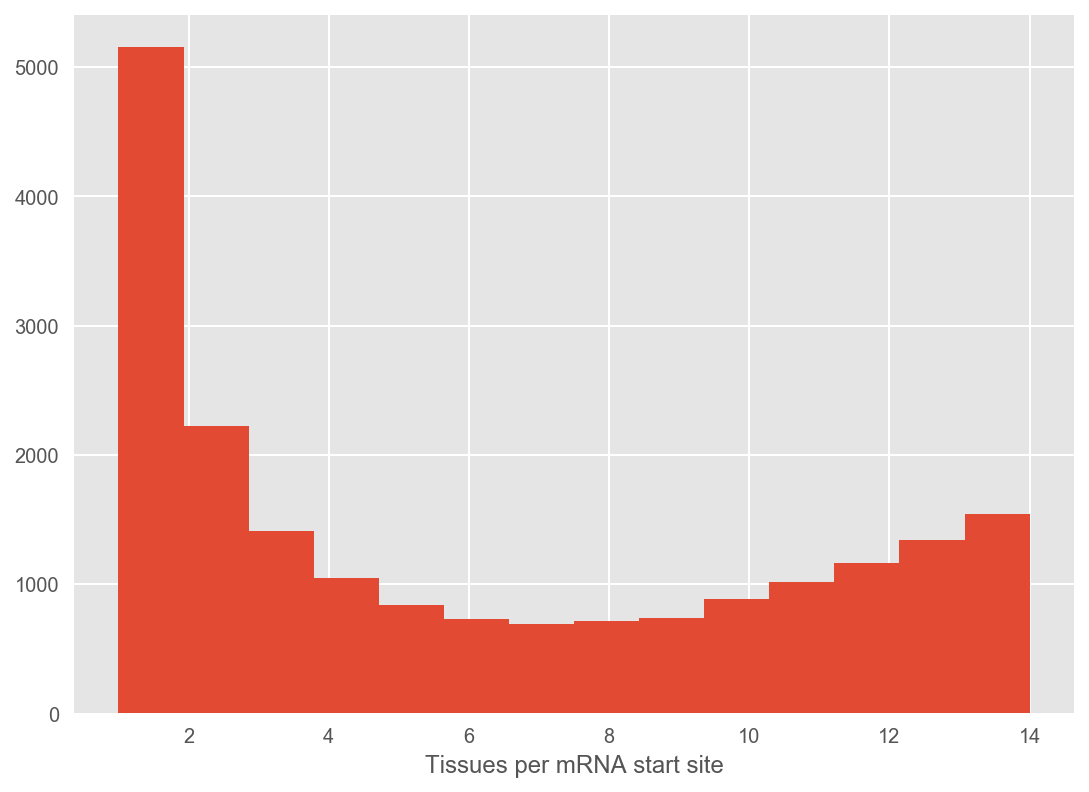

In [101]:
f = plt.figure()
ax = f.add_subplot(111)
#ax = sns.distplot(experimental_tss['tissues'].apply(lambda x:len(x)),kde=False)
tissues_count = experimental_tss['tissues'].apply(lambda x:len(x))
ax.hist(tissues_count,bins=max(tissues_count))
ax.set_xlabel('Tissues per mRNA start site')
plt.savefig('Results/Figures/experimental_tss.png')

## Using the nearest peak, no distance. See if the ones that dont have a gene may have potential start site

# Get peak start sites

In [23]:
gene_hasTSS = gene_tss[gene_tss['hasGene']] #Ones that have gene
gene_hasTSS = gene_hasTSS[~gene_hasTSS.index.duplicated()]
gene_hasTSS['is_in_cho_promoter'] = False
gene_hasTSS['maxPeak'] = ''
gene_hasTSS['Chr'] = ''
gene_hasTSS['Start'] = 0
gene_hasTSS['End'] = 0
gene_hasTSS['Strand'] = ''
gene_hasTSS['Distance to Annotated TSS'] = 0
gene_hasTSS['transcript_id'] = ''
gene_hasTSS['gene_id'] = ''


count = 0
for ind,val in gene_hasTSS.iterrows():
    curr_gene_peaks = peak_tissue_matrix[peak_tissue_matrix.index.isin(val['sameStrandPeaks'])]
    is_in_cho_wideRange = cho[cho.index.isin(val['Peaks'])]
    is_in_cho_promoter = cho[cho.index.isin(val['sameStrandPeaks'])]
    
    if np.sum(np.sum(is_in_cho_wideRange>0)) > 0:
        gene_hasTSS.set_value(ind,'is_in_cho_all', True)
    if np.sum(np.sum(is_in_cho_promoter>0)) > 0:
        gene_hasTSS.set_value(ind,'is_in_cho_promoter', True)        

    if len(curr_gene_peaks) > 1:
        max_peak = curr_gene_peaks.max(axis=1).argmax()
        max_value = curr_gene_peaks.max(axis=1).max()
    else:
        max_peak = curr_gene_peaks.index[0]
        max_value = curr_gene_peaks.max().max()
    tmp = anno_peaks.loc[max_peak]
    
    gene_hasTSS.set_value(ind,'maxValue',max_value)
    gene_hasTSS.set_value(ind,'transcript_id',tmp['Nearest TSS'])
    gene_hasTSS.set_value(ind,'gene_id',tmp['Nearest gene_id'])
    gene_hasTSS.set_value(ind,'Start',tmp['Start'])
    gene_hasTSS.set_value(ind,'End',tmp['End'])
    gene_hasTSS.set_value(ind,'Chr',tmp['Chr'])
    gene_hasTSS.set_value(ind,'Strand',tmp['Strand'])
    gene_hasTSS.set_value(ind,'Distance to Annotated TSS',tmp['Distance to TSS'])

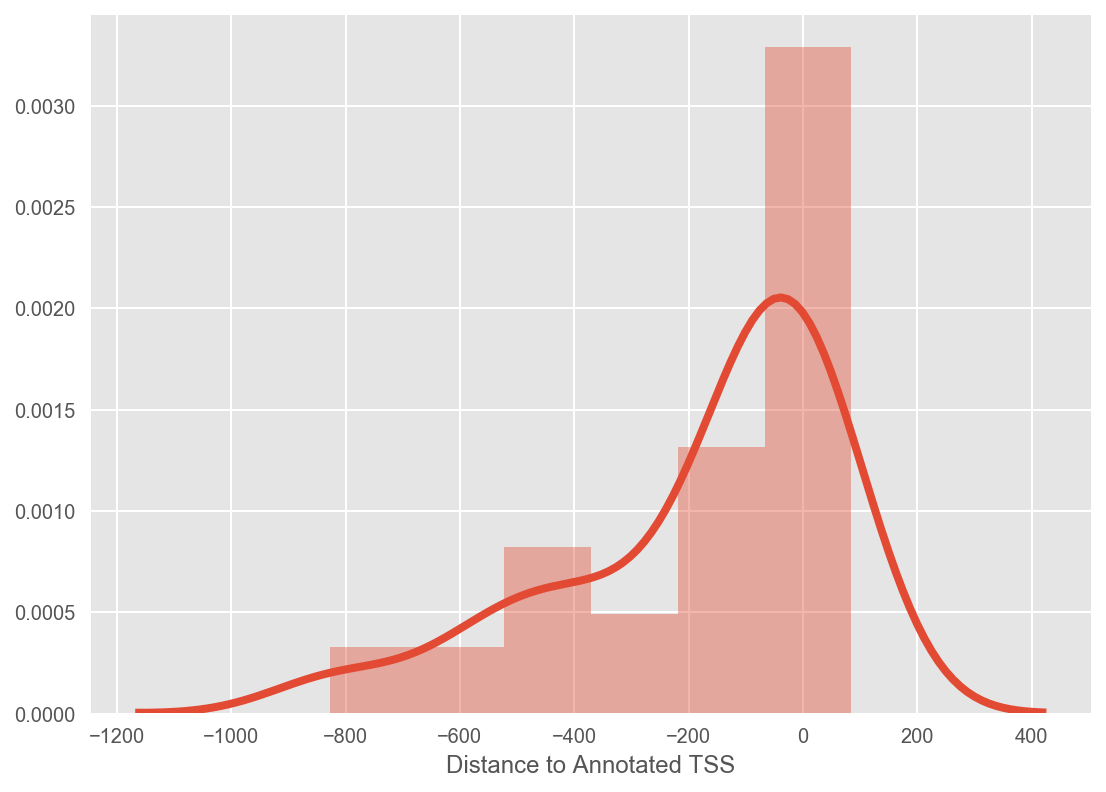

In [24]:
sns.distplot(experimental_tss['Distance to Annotated TSS'])

In [111]:
## Putting into bed format
tss_peakCenter_bed = pd.DataFrame()
for ind,val in experimental_tss.iterrows():
    title = '%s;%s;%s;%s;%d' % (val['gene'],val['gene_id'],ind,','.join(val['tissues']),val['cs'])

    tss_peakCenter_bed = tss_peakCenter_bed.append({'chrom':val['Chr'], 
                                'chromStart': val['Start'],
                                'chromEnd':val['End'],
                                'name':title,
                                'score': val['max_value'],
                                'strand':val['Strand']},ignore_index=True)

    
tss_peakCenter_bed = tss_peakCenter_bed[['chrom','chromStart','chromEnd','name','score','strand']]
tss_peakCenter_bed['chromStart'] = tss_peakCenter_bed['chromStart'].astype(int)
tss_peakCenter_bed['chromEnd'] = tss_peakCenter_bed['chromEnd'].astype(int)

In [112]:
f_save = 'Results/tss_final/tss_peakCenter'
tss_peakCenter_bed.to_csv(f_save + '.bed',sep='\t',header=None,index=None)

In [113]:
tss_peakCenter_bed.head()

,chrom,chromStart,chromEnd,name,score,strand
0,picr_0,20879,21067,"SERHL;gene_1_4;asmbl_14;BMDMwt,Heart,FemaleRep...",1089.349976,+
1,picr_0,44414,44574,"RRP7A;gene_2;asmbl_10;MiscOrgans,Brain,CHO,Spl...",91.099998,-
2,picr_0,45849,45999,RRP7A;gene_2;asmbl_4;CHO;1,24.400000,-
3,picr_0,78182,78421,"POLDIP3;gene_3_1;asmbl_19;BMDMwt,Heart,FemaleR...",367.649994,-
4,picr_0,92130,92280,"CYB5R3;gene_3_2;asmbl_20;BMDMwt,BloondnegSpleen;2",45.099998,-


In [118]:
upstream,downstream = 500,500

tss_500_up_down_bed = pd.DataFrame()
for ind,val in experimental_tss.iterrows():
    title = '%gs;%s;%s;cs:%d;%s' % (val['gene'],val['gene_id'],ind,','.join(val['tissues']),val['cs'])
    center = (val['Start'] + val['End'])/2
    
    if val['Strand'] == '+':
        start = center-upstream+1
        end = center + downstream
    elif val['Strand'] == '-':
        start = center - downstream
        end = center + upstream - 1
    
    
    tss_500_up_down_bed = tss_500_up_down_bed.append({'chrom':val['Chr'], 
                                'chromStart': start,
                                'chromEnd':end,
                                'name':title,
                                'score': val['max_value'],
                                'strand':val['Strand']},ignore_index=True)

    
tss_500_up_down_bed = tss_500_up_down_bed[['chrom','chromStart','chromEnd','name','score','strand']]
tss_500_up_down_bed['chromStart'] = tss_500_up_down_bed['chromStart'].astype(int)
tss_500_up_down_bed['chromEnd'] = tss_500_up_down_bed['chromEnd'].astype(int)

In [119]:
tss_500_up_down_bed

,chrom,chromStart,chromEnd,name,score,strand
0,picr_0,20474,21473,"SERHL;gene_1_4;asmbl_14;BMDMwt,Heart,FemaleRep...",1089.349976,+
1,picr_0,43994,44993,"RRP7A;gene_2;asmbl_10;MiscOrgans,Brain,CHO,Spl...",91.099998,-
2,picr_0,45424,46423,RRP7A;gene_2;asmbl_4;CHO;1,24.400000,-
3,picr_0,77801,78800,"POLDIP3;gene_3_1;asmbl_19;BMDMwt,Heart,FemaleR...",367.649994,-
4,picr_0,91705,92704,"CYB5R3;gene_3_2;asmbl_20;BMDMwt,BloondnegSpleen;2",45.099998,-
5,picr_0,98322,99321,"POLDIP3;gene_3_1;asmbl_17;BMDMwt,Heart,FemaleR...",1550.399902,-
6,picr_0,185230,186229,"A4GALT;gene_4_3;asmbl_30;BMDMwt,Heart,FemaleRe...",345.149994,-
7,picr_0,185788,186787,"A4GALT;gene_4_3;asmbl_24;BMDMwt,Lung,Kidney,Bl...",95.199997,-
8,picr_0,275172,276171,"ARFGAP3;gene_5_1;asmbl_33;BMDMwt,Heart,FemaleR...",570.200012,-
9,picr_0,297715,298714,"ARFGAP3;gene_5_1;asmbl_31;BMDMwt,Spleen,MiscOr...",3116.100098,-


In [120]:
f_save = 'Results/tss_final/tss_500bp_up_500bp_down'
tss_500_up_down_bed.to_csv(f_save + '.bed',sep='\t',header=None,index=None)

In [121]:
cmd = 'homerTools extract %s %s -fa > %s' % (f_save + '.bed', ref_fa,f_save +'.fa')
print(cmd)
os.system(cmd)

homerTools extract Results/tss_final/tss_500bp_up_500bp_down.bed /data/genome/hamster/picr/picr.fa -fa > Results/tss_final/tss_500bp_up_500bp_down.fa


0

### Same but for gene